#### **<u>Prep CESM Data </u>**


**Tech Preamble**

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

#### **Step 1 - Select Area**

load **one** Dataset and find indices

In [2]:
original_file_path = "/data/Hannah/data/ctrl.g.e11.G.T62_t12.002.pop.h.0041-12-30.nc"

original_ds = xr.open_dataset(original_file_path)

**Example: Kuro**

In [ ]:
lat_min, lat_max = -45, -35   
lon_min, lon_max = 290, 310 

lat = original_ds['TLAT']
lon = original_ds['TLONG']

lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[1]

print(f"Latitude indices min: {lat_indices.min()}, max: {lat_indices.max()}")
print(f"Longitude indices min: {lon_indices.min()}, max: {lon_indices.max()}")

Latitude indices min: 677, max: 807
Longitude indices min: 400, max: 899


ESTIMATE - manually crop so it's a nice region with 2^n

#### **Step 2 - Switch to TERMINAL and use nco to chunk data**

**2.1 Do it for one dataset and check**

**Example: Kuro**


ssh into TH02


_Create the output directory_

<br>

mkdir -p /data/Hannah/Kuro_new_2

<br>

_Run the ncks command with the specified latitude and longitude ranges_

<br>

ncks -4 -O \
  -d nlat,1436,1691 -d nlon,2300,2811 \
  --cnk_dmn nlat,50 --cnk_dmn nlon,50 \
  /data/Hannah/data/ctrl.g.e11.G.T62_t12.002.pop.h.0041-12-30.nc \
  /data/Hannah/Kuro_new_2/test.nc


In [ ]:
file_path = "/data/Hannah/Kuro_new_2/test.nc"
chunked_ds = xr.open_dataset(file_path)

ssh = chunked_ds['SSH']

In [9]:
ssh.shape

(1, 256, 512)

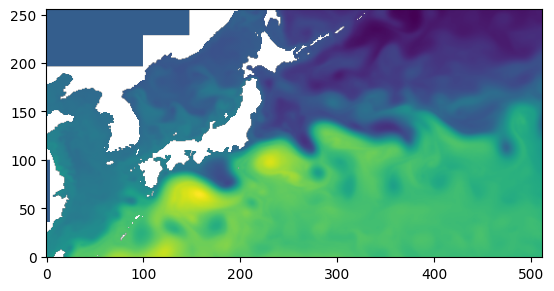

In [10]:
plt.imshow(ssh.isel(time = 0), origin = "lower")
plt.show()

**2.2 Repeat for all datasets**

**modify** and run bash script in screen 

<br>

./work/esn/CESM/chunk_all_files.sh

<br>

_this may take a few hours ... (~16h)_

take speacial care to change: 

- input/ output path 
- coordinates max/ min


and check here

In [2]:
original_file_path = "/data/Hannah/Kuro_new_2/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0041-12-27.nc"
ds = xr.open_dataset(original_file_path)

In [3]:
ssh = ds['SSH']

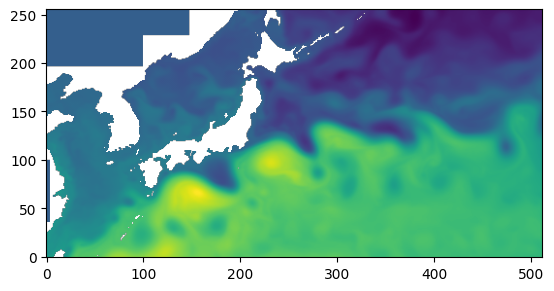

In [4]:
plt.imshow(ssh.isel(time = 0), origin = "lower")
plt.show()

#### **Step 3 - Regrid and interpolate**

SSH into TH02, start screen terminal

_actiate conda environment via_

<br>

source ~/miniconda3/bin/activate myenv

<br>

_cd to work/esn_ 

**modify region**

_run via_ 

<br>

python3 CESM/regridding.py

<br>


_wait..._

then check here 

In [9]:
ssh = np.load("Data/ssh_Kuro_new_2.npy")

In [10]:
ssh.shape

(2068, 130, 140)

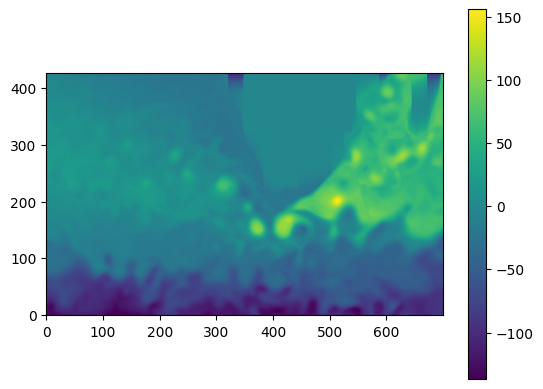

In [197]:
plt.imshow(ssh[0,:,:], origin="lower")
plt.colorbar()
plt.show()

In [7]:
mask = np.load("../land_mask_AL.npy")

In [8]:
mask.shape

(427, 700)

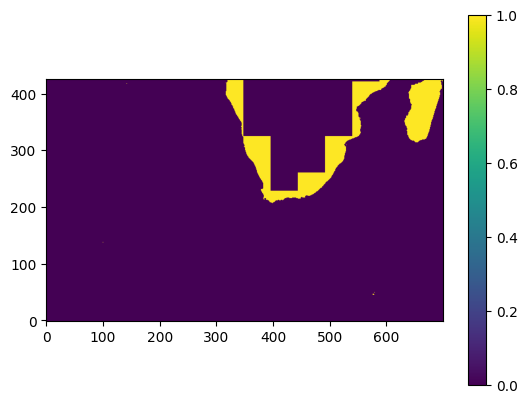

In [11]:
plt.imshow(mask[:], origin="lower")
plt.colorbar()
plt.show()